Summary
===
My coworkers and I are in a Fantasy Movie League group together, which means we all get to vote on movies we expect to outperform their professional forecasts every weekend, and we keep track of our progress over a season of ~13 weeks. I felt like doing some forecasting and realized that Fantasy Movie League was a great candidate for that kind of work. In this script you'll find quite a bit of web scraping, some string manipulation to programatically generate URLs to scrape, and then forecasting code. The output is a bunch of forecasts and then a table with the projected sum for all the available FML movies (that have been out long enough to forecast) for the coming weekend. I am also working on other scripts so my bot can fully compete in the league, including attempting regression to predict opening weekend movie earnings and optimization of the lineup.

Enjoy!

In [1]:
#Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
import requests
import datetime
from bs4 import BeautifulSoup
%matplotlib inline

#Turn off chained assignment warnings
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#Get the list of available movies and metadata from FML
r = requests.get("https://fantasymovieleague.com/researchvault?section=box-office")
soup = BeautifulSoup(r.content, 'lxml')

#Find the relevant table, clean it up
table = soup.find_all('table')[0]
df = pd.read_html(str(table))[0]
df.drop(df.columns[0], axis=1, inplace=True) #The HTML table has an extra column of 1-indexed ranks
df.columns = df.columns.droplevel() #The HTML table has an erroneous multi-index

#Split name column to get FML price and name stored separately
df["price"] = df.iloc[:,0].str.split("$", n=0, expand=True)[1]
df["name"] = df.iloc[:,0].str.split("FB", n=0, expand=True)[0]
firststep = df.drop(df.columns[0], axis = 1) #Drop the old name column
firststep

,Earnings,%Change,Earnings,%Change,Earnings,%Change,Earnings,%Change,price,name
0,$28.1M,-,-,-,-,-,-,-,167,Pacific Rim Uprising
1,$17.1M,-35.8%,$26.7M,-34.7%,$40.8M,-,-,-,148,Black Panther
2,$13.6M,-20.5%,$17.1M,-,-,-,-,-,153,I Can Only Imagine
3,$10.6M,-,-,-,-,-,-,-,91,Sherlock Gnomes
4,$10.1M,-57.3%,$23.6M,-,-,-,-,-,65,Tomb Raider
5,$8.2M,-49.5%,$16.3M,-50.9%,$33.1M,-,-,-,54,A Wrinkle in Time
6,$7.6M,-35.3%,$11.8M,-,-,-,-,-,71,"Love, Simon"
7,$5.2M,-,-,-,-,-,-,-,41,"Paul, Apostle of Christ"
8,$4.1M,-26.3%,$5.6M,-28.8%,$7.9M,-24.5%,$10.4M,-38.8%,41,Game Night
9,$4.0M,-,-,-,-,-,-,-,28,Midnight Sun


In [3]:
#Deal with the special case of Blockbuster movies being split by day
firststep["day"] = 'ALL'
cleaned = firststep
days = ['FRI','SAT','SUN']

#If movie is split by day, store that row's day in "day" column
try:
    cleaned.loc[cleaned.name.str.contains('|'.join(days)),"day"] = cleaned[
        cleaned.name.str.contains('|'.join(days))].name.str.split(" - ", n=0, expand=True)[0]
    
    #If movie is split by day, store that row's cleaned name in "name" column
    cleaned.loc[cleaned.name.str.contains('|'.join(days)),"name"] = cleaned[
        cleaned.name.str.contains('|'.join(days))].name.str.split(" - ", n=0, expand=True)[1]
except KeyError:
    print("Looks like no movies are split by day this week! Yay!")

#Rename columns, drop irrelevant columns
cleaned.columns.values[[0,2,4,6]] = ["lastweek","2weeksago","3weeksago","4weeksago"]
final = cleaned.drop(cleaned.columns[[1,3,5,7]], axis = 1)
final

Looks like no movies are split by day this week! Yay!


,lastweek,2weeksago,3weeksago,4weeksago,price,name,day
0,$28.1M,-,-,-,167,Pacific Rim Uprising,ALL
1,$17.1M,$26.7M,$40.8M,-,148,Black Panther,ALL
2,$13.6M,$17.1M,-,-,153,I Can Only Imagine,ALL
3,$10.6M,-,-,-,91,Sherlock Gnomes,ALL
4,$10.1M,$23.6M,-,-,65,Tomb Raider,ALL
5,$8.2M,$16.3M,$33.1M,-,54,A Wrinkle in Time,ALL
6,$7.6M,$11.8M,-,-,71,"Love, Simon",ALL
7,$5.2M,-,-,-,41,"Paul, Apostle of Christ",ALL
8,$4.1M,$5.6M,$7.9M,$10.4M,41,Game Night,ALL
9,$4.0M,-,-,-,28,Midnight Sun,ALL


In [4]:
#Before getting daily numbers from the-numbers.com, we need movie names in the format the-numbers uses for URLs.
#Luckily, the-numbers.com has somewhat consistent URL conventions!

final["url_part"] = final["name"]

the_mask = final["url_part"].str.startswith("The ")
final.loc[the_mask, "url_part"] = final.loc[the_mask, "url_part"].str.replace("The ","") + " The" #Move "The" to end
final["url_part"] = final["url_part"].str.replace(' ', '-')

#colons with a space after are removed (as in "Jumani: "), and other string cleaning
final["url_part"] = final["url_part"].str.replace('[: ]+','')

#some other common characters will be removed in the-numbers.com URLs
final["url_part"] = final["url_part"].str.replace('[,!.\']+','')

#colons within words or numbers (as in "15:17") are replaced with dashes
final["url_part"] = final["url_part"].str.replace(':', '-')
final

,lastweek,2weeksago,3weeksago,4weeksago,price,name,day,url_part
0,$28.1M,-,-,-,167,Pacific Rim Uprising,ALL,Pacific-Rim-Uprising
1,$17.1M,$26.7M,$40.8M,-,148,Black Panther,ALL,Black-Panther
2,$13.6M,$17.1M,-,-,153,I Can Only Imagine,ALL,I-Can-Only-Imagine
3,$10.6M,-,-,-,91,Sherlock Gnomes,ALL,Sherlock-Gnomes
4,$10.1M,$23.6M,-,-,65,Tomb Raider,ALL,Tomb-Raider
5,$8.2M,$16.3M,$33.1M,-,54,A Wrinkle in Time,ALL,A-Wrinkle-in-Time
6,$7.6M,$11.8M,-,-,71,"Love, Simon",ALL,Love-Simon
7,$5.2M,-,-,-,41,"Paul, Apostle of Christ",ALL,Paul-Apostle-of-Christ
8,$4.1M,$5.6M,$7.9M,$10.4M,41,Game Night,ALL,Game-Night
9,$4.0M,-,-,-,28,Midnight Sun,ALL,Midnight-Sun


In [5]:
#This function takes in one of the cleaned URL_parts we made above and grabs the associated data from the-numbers.com
#The URLs sometimes have year designations on the end, sometimes not... so we have to check for all of them!

def get_boxoffice_table(row):
    try:
        r = requests.get("https://www.the-numbers.com/movie/{}-(2018)".format(row))
        soup = BeautifulSoup(r.content, 'lxml')
        table = soup.find_all(id = 'box_office_chart')[1]   
        movie = pd.read_html(str(table))[0]
        movie.columns = movie.iloc[0]
        movie = movie[1:]
        movie["Gross"] = movie["Gross"].str.replace('\$|,','')
        print("Found and stored data for {}-(2018)!".format(row))
        return movie
    except IndexError: #the-numbers.com sometimes includes movie year, sometimes does not
        print("No luck finding {}-(2018), will try adding -(2017)".format(row))
        try:
            r = requests.get("https://www.the-numbers.com/movie/{}-(2017)".format(row))
            soup = BeautifulSoup(r.content, 'lxml')
            table = soup.find_all(id = 'box_office_chart')[1]   
            movie = pd.read_html(str(table))[0]
            movie.columns = movie.iloc[0]
            movie = movie[1:]
            movie["Gross"] = movie["Gross"].str.replace('\$|,','')
            print("Found and stored data for {}-2017!".format(row))
            return movie
        except IndexError: #the-numbers.com sometimes includes movie year, sometimes does not
            print("No luck finding {}-(2017), will try adding -(2016)".format(row))
            try:
                r = requests.get("https://www.the-numbers.com/movie/{}-(2016)".format(row))
                soup = BeautifulSoup(r.content, 'lxml')
                table = soup.find_all(id = 'box_office_chart')[1]   
                movie = pd.read_html(str(table))[0]
                movie.columns = movie.iloc[0]
                movie = movie[1:]
                movie["Gross"] = movie["Gross"].str.replace('\$|,','')
                print("Found and stored data for {}-2016!".format(row))
                return movie
            except IndexError: #the-numbers.com mislabeled "Death With" as from 2017...
                print("No luck finding {}-(2016) either. Will try removing year specification.".format(row))
                try:
                    r = requests.get("https://www.the-numbers.com/movie/{}".format(row))
                    soup = BeautifulSoup(r.content, 'lxml')
                    table = soup.find_all(id = 'box_office_chart')[1]   
                    movie = pd.read_html(str(table))[0]
                    movie.columns = movie.iloc[0]
                    movie = movie[1:]
                    movie["Gross"] = movie["Gross"].str.replace('\$|,','')
                    print("Found and stored data for {}!".format(row))
                    return movie
                except IndexError:
                    print("Looks like {} doesn't exist on the-numbers.com. Try a google search?".format(row))

In [16]:
#Incredibly, the forecast part is one of the easiest.

def forecast(df):
    #fbprophet requires one "y" column for values and one "ds" column for dates
    try:
        df["old_y"] = pd.to_numeric(df["Gross"])
        df["y"] = np.log(pd.to_numeric(df["Gross"]))
        df["ds"] = pd.to_datetime(df["Date"], format = '%Y/%m/%d')
        m = Prophet(changepoint_prior_scale=.5) #default 0.05, higher values make the trend fit more flexible
        m.fit(df)
        future_data = m.make_future_dataframe(periods=7) #forecast a week to make sure we capture next week's numbers
        fcast_data = m.predict(future_data)
        fig, ax = plt.subplots(figsize=(10,6))
        ax.plot(fcast_data["ds"],np.exp(fcast_data["yhat"]), linestyle = '--')
        ax.plot(df["ds"], df["old_y"])
        ax.set_ylabel("Forecast of Daily Gross")
        ax.set_title(row)
        plt.show()
        fcast_data["day"] = fcast_data["ds"].dt.weekday_name
        day_abb = {"Monday" : "MON"
           , "Tuesday" : "TUE"
           , "Wednesday" : "WED"
           , "Thursday" : "THU"
           , "Friday" : "FRI"
           , "Saturday" : "SAT"
           , "Sunday" : "SUN"}
        fcast_data["day"] = fcast_data["day"].map(day_abb)
        return fcast_data
    except TypeError:
        print("This is likely a new movie, which can't be forecasted yet! Moving on. \n")

No luck finding Pacific-Rim-Uprising-(2018), will try adding -(2017)
No luck finding Pacific-Rim-Uprising-(2017), will try adding -(2016)
No luck finding Pacific-Rim-Uprising-(2016) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 3.0.


Found and stored data for Pacific-Rim-Uprising!


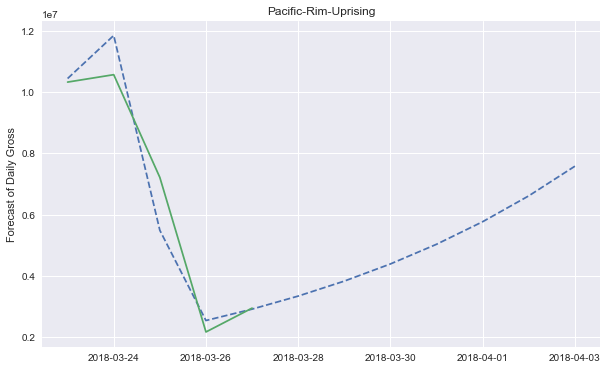

Setting to new movie
No luck finding Black-Panther-(2018), will try adding -(2017)
No luck finding Black-Panther-(2017), will try adding -(2016)
No luck finding Black-Panther-(2016) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Found and stored data for Black-Panther!


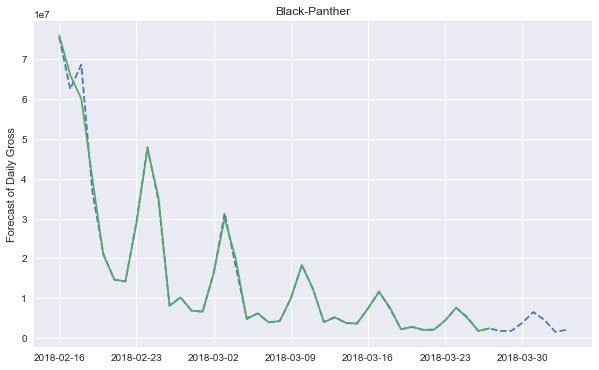

Setting to weekend_sum
No luck finding I-Can-Only-Imagine-(2018), will try adding -(2017)
No luck finding I-Can-Only-Imagine-(2017), will try adding -(2016)
No luck finding I-Can-Only-Imagine-(2016) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 8.0.


Found and stored data for I-Can-Only-Imagine!


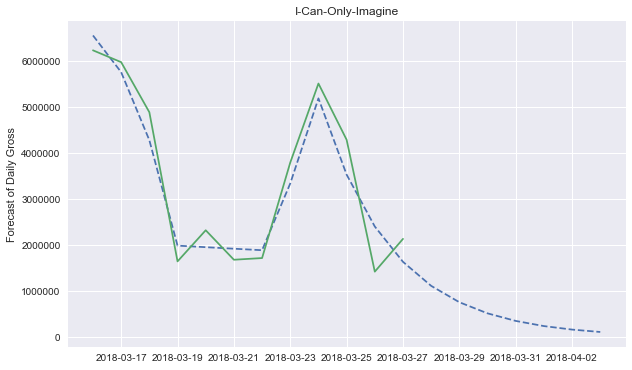

Setting to new movie


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 3.0.


Found and stored data for Sherlock-Gnomes-(2018)!


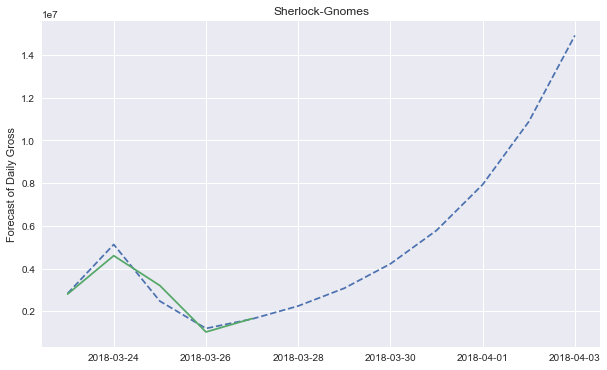

Setting to new movie


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 8.0.


Found and stored data for Tomb-Raider-(2018)!


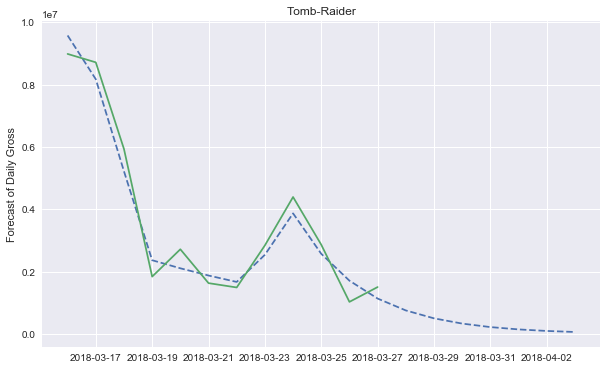

Setting to new movie
No luck finding A-Wrinkle-in-Time-(2018), will try adding -(2017)
No luck finding A-Wrinkle-in-Time-(2017), will try adding -(2016)
No luck finding A-Wrinkle-in-Time-(2016) either. Will try removing year specification.
Looks like A-Wrinkle-in-Time doesn't exist on the-numbers.com. Try a google search?
This is likely a new movie, which can't be forecasted yet! Moving on. 

No luck finding Love-Simon-(2018), will try adding -(2017)
No luck finding Love-Simon-(2017), will try adding -(2016)
No luck finding Love-Simon-(2016) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 8.0.


Found and stored data for Love-Simon!


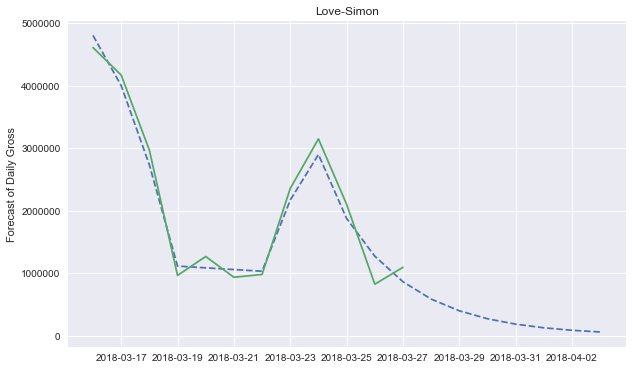

Setting to new movie
No luck finding Paul-Apostle-of-Christ-(2018), will try adding -(2017)
No luck finding Paul-Apostle-of-Christ-(2017), will try adding -(2016)
No luck finding Paul-Apostle-of-Christ-(2016) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 3.0.


Found and stored data for Paul-Apostle-of-Christ!


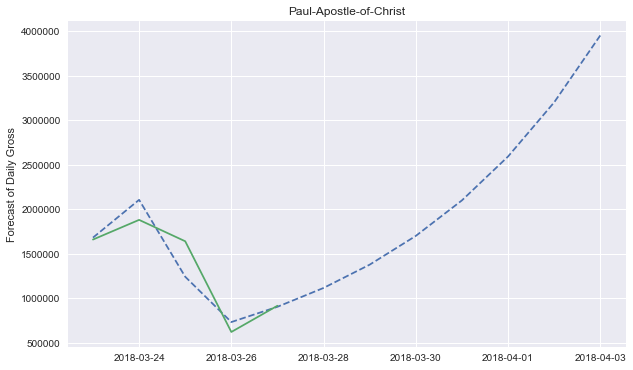

Setting to new movie


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Found and stored data for Game-Night-(2018)!


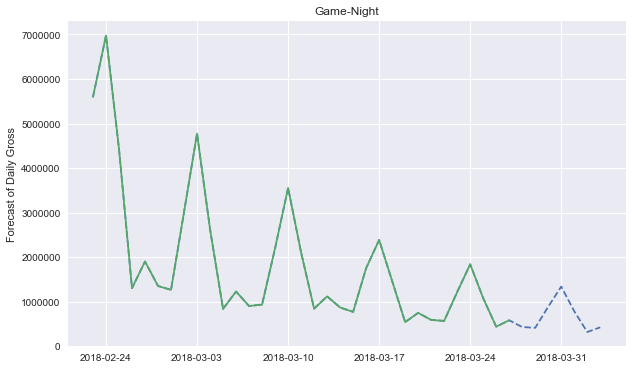

Setting to weekend_sum


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 1.0.


Found and stored data for Midnight-Sun-(2018)!


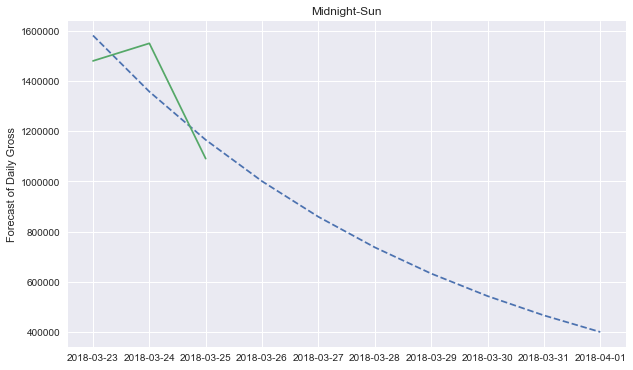

Setting to new movie
No luck finding Unsane-(2018), will try adding -(2017)
No luck finding Unsane-(2017), will try adding -(2016)
No luck finding Unsane-(2016) either. Will try removing year specification.


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 1.0.


Found and stored data for Unsane!


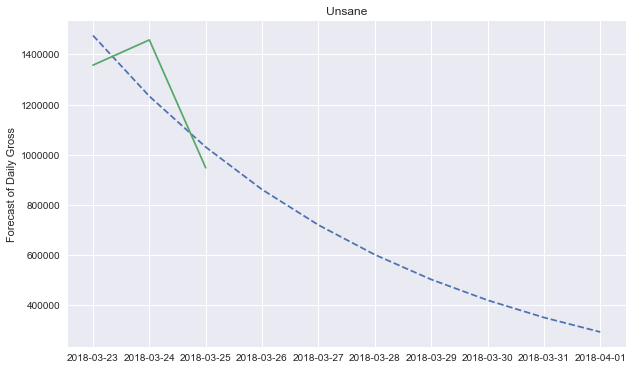

Setting to new movie
No luck finding Gods-Not-Dead-A-Light-in-Darkness-(2018), will try adding -(2017)
No luck finding Gods-Not-Dead-A-Light-in-Darkness-(2017), will try adding -(2016)
No luck finding Gods-Not-Dead-A-Light-in-Darkness-(2016) either. Will try removing year specification.
Looks like Gods-Not-Dead-A-Light-in-Darkness doesn't exist on the-numbers.com. Try a google search?
This is likely a new movie, which can't be forecasted yet! Moving on. 



INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 3.0.


Found and stored data for Isle-of-Dogs-(2018)!


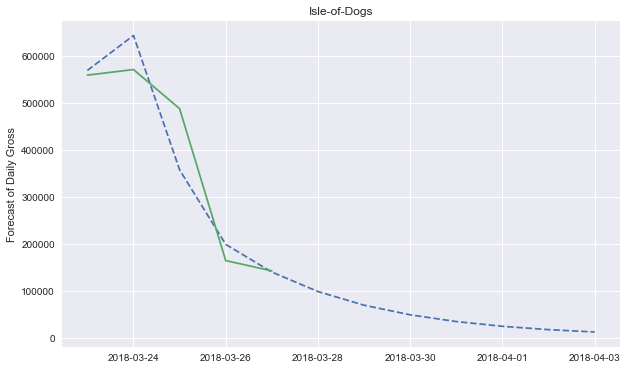

Setting to new movie
No luck finding Ready-Player-One-(2018), will try adding -(2017)
No luck finding Ready-Player-One-(2017), will try adding -(2016)
No luck finding Ready-Player-One-(2016) either. Will try removing year specification.
Looks like Ready-Player-One doesn't exist on the-numbers.com. Try a google search?
This is likely a new movie, which can't be forecasted yet! Moving on. 

No luck finding Tyler-Perrys-Acrimony-(2018), will try adding -(2017)
No luck finding Tyler-Perrys-Acrimony-(2017), will try adding -(2016)
No luck finding Tyler-Perrys-Acrimony-(2016) either. Will try removing year specification.
Looks like Tyler-Perrys-Acrimony doesn't exist on the-numbers.com. Try a google search?
This is likely a new movie, which can't be forecasted yet! Moving on. 



In [26]:
#This loop runs through all of the available movies in FML and attempts to forecast their future performance
#It then stores them in a dictionary (to be made a dataframe and merged with another later)

weekend_estimates = {}
for row in final["url_part"]:
    movie = get_boxoffice_table(row)
    fcast_data = forecast(movie)
    try:
        fcast_data["yhat_exp"] = np.exp(fcast_data["yhat"])
        weekend_sum = fcast_data[(fcast_data["ds"] >= datetime.date.today())
            & (fcast_data["day"].isin(days))]["yhat_exp"].sum()
        if fcast_data[fcast_data["ds"] < datetime.date.today()].shape[0] < 13:
            print("Setting to new movie")
            weekend_estimates[row] = "New movie"
        else:
            print("Setting to weekend_sum")
            weekend_estimates[row] = weekend_sum
    except TypeError:
        weekend_estimates[row] = "New movie"

In [27]:
#Create dataframe from forecast estimates, merge with our other df
estimates = pd.DataFrame.from_dict(weekend_estimates, orient='index')
estimates.reset_index(inplace=True)
estimates.columns = ["url_part", "estimate"]
merged = final.merge(estimates, on = "url_part")
merged

,lastweek,2weeksago,3weeksago,4weeksago,price,name,day,url_part,estimate
0,$28.1M,-,-,-,167,Pacific Rim Uprising,ALL,Pacific-Rim-Uprising,New movie
1,$17.1M,$26.7M,$40.8M,-,148,Black Panther,ALL,Black-Panther,1.49386e+07
2,$13.6M,$17.1M,-,-,153,I Can Only Imagine,ALL,I-Can-Only-Imagine,New movie
3,$10.6M,-,-,-,91,Sherlock Gnomes,ALL,Sherlock-Gnomes,New movie
4,$10.1M,$23.6M,-,-,65,Tomb Raider,ALL,Tomb-Raider,New movie
5,$8.2M,$16.3M,$33.1M,-,54,A Wrinkle in Time,ALL,A-Wrinkle-in-Time,New movie
6,$7.6M,$11.8M,-,-,71,"Love, Simon",ALL,Love-Simon,New movie
7,$5.2M,-,-,-,41,"Paul, Apostle of Christ",ALL,Paul-Apostle-of-Christ,New movie
8,$4.1M,$5.6M,$7.9M,$10.4M,41,Game Night,ALL,Game-Night,3.01102e+06
9,$4.0M,-,-,-,28,Midnight Sun,ALL,Midnight-Sun,New movie


Everything below this point is in progress
===